In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math
from statsmodels.tsa.arima.model import ARIMA
import random
from scipy.special import iv
from scipy.linalg import expm, sinm, cosm

In [12]:
# data = pd.read_excel('C:/Users/michelj8/Documents/GitHub/expo_smooth_lasso/METS/farm_output.xlsx', sheet_name = 'data')
data = pd.read_excel('C:/Users/michelj8/Documents/GitHub/expo_smooth_lasso/METS/fred_household_income.xls', sheet_name = 'data')
# ts = data['Dairy'].diff().dropna()
ts = data['MEHOINUSA672N'].diff().dropna()

sample_size = len(ts)

In [13]:
def mets_forecast(alpha, phi,Y , max_length):
    if len(Y) < max_length:
        np.append( np.zeros(max_length - len(Y)), Y)
        
    Y = np.flip(Y[-max_length:])
    return alpha - 1.0*np.sum([y*phi**h/math.factorial(h) for y,h in zip(Y,range(1,max_length-1))])

def multi_mets_forecast(alpha,phi,Y,max_length, forecast_length):
    for k in range(0, forecast_length):
        Y = np.append(Y, mets_forecast(alpha,phi, Y, max_length))
    return Y

In [14]:
def mets_filter(ts,phi,alpha):
    ts_mean = np.mean(ts)
    ts = np.append(ts,ts_mean)
    sample_size = len(ts)
    
    L_approx = np.zeros([sample_size, sample_size])

    for row in range(0,len(L_approx)-1):
        L_approx[row][row+1] =1

    L_approx[sample_size -1 ] = np.ones(sample_size)/sample_size
    filter_matrix = expm(phi*L_approx)
    
    output = np.dot(filter_matrix,ts) + alpha

    return output[:-1]

def ols_mets(ts,grid_size):
    min_alpha = 0.0
    min_rho = 0.0
    min_obj = np.square(mets_filter(ts, 0.0, 0.0)).mean()
    ts_mean  = np.mean(ts)
    
    for alpha in np.linspace(-ts_mean, ts_mean, grid_size):
        for rho in np.linspace(-2,2,grid_size):
            obj = np.square(mets_filter(ts, rho, alpha)).mean()
            
            if obj < min_obj:
                min_alpha = alpha
                min_rho = rho
                min_obj = obj
                
    return [min_alpha, min_rho]

In [15]:
mets_fit = ols_mets(ts,25)
mets_fit

[-381.5238095238095, -0.16666666666666674]

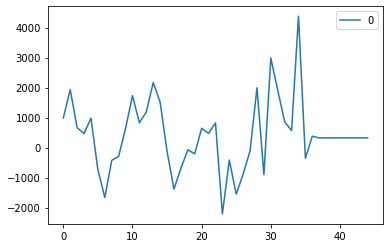

In [16]:
pd.DataFrame(multi_mets_forecast(-mets_fit[0], -mets_fit[1], ts, 10,10)).plot()

In [17]:
from statsmodels.tsa.arima.model import ARIMA

arma_model = ARIMA(ts, order=(1, 0, 0)).fit()
ar_coefs = arma_model.params
print(ar_coefs)

const     4.578287e+02
ar.L1     3.486101e-01
sigma2    1.706282e+06
dtype: float64


C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


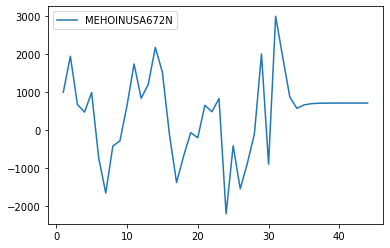

In [18]:
ar_ts = ts.copy()
for time in range(len(ts),len(ts)+10):
    ar_ts[time] = ar_coefs[0]+ar_coefs[1]*ar_ts[time-1]
    
pd.DataFrame(ar_ts).plot()

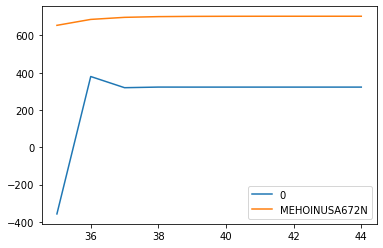

In [23]:
fig, ax = plt.subplots()

pd.DataFrame(multi_mets_forecast(-mets_fit[0], -mets_fit[1], ts, 15,10)).loc[sample_size:].plot(ax=ax)
pd.DataFrame(ar_ts).loc[sample_size:].plot(ax = ax)